In [36]:
from pathlib import Path
from scipy.io import mmread
from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np
import scanpy as sc
import decoupler as dc
import anndata as ad
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

WORKSPACE_ROOT = Path("../../").resolve()
Path("./cache").mkdir(exist_ok=True)

In [37]:
data_dir = WORKSPACE_ROOT/"data/hcmv/processed_data_files"
todo = ["HCMV1", "HCMV2", "mock1", "mock2"]

sample_bars = {}
sample_genes = {}
for sample_name in todo:
    df_gene = pd.read_csv(data_dir/f"{sample_name}-features.tsv", sep="\t", header=None)
    df_gene = df_gene.iloc[:, 0:2]
    df_gene.columns = ["locus", "gene"]
    sample_genes[sample_name] = df_gene

    df_bar = pd.read_csv(data_dir/f"{sample_name}-barcodes.tsv", sep="\t", header=None)
    df_bar = df_bar.iloc[:, 0:1]
    df_bar.columns = ["barcode"]
    sample_bars[sample_name] = df_bar

def make_index_map(df):
    x2i = pd.DataFrame(df)
    x2i.set_index("locus", inplace=True)
    x2i["ival"] = np.arange(len(df))
    return x2i

_dfs = list(sample_genes.values())
df_allg = pd.DataFrame(_dfs[0])
for _df in _dfs[1:]:
    df_allg = pd.merge(df_allg, _df, how="outer", on="locus")
    df_allg["gene_x"].fillna(df_allg["gene_y"], inplace=True)
    df_allg.columns = [c.replace("_x", "") for c in df_allg.columns]
    df_allg = df_allg[["locus", "gene"]]

mats = {}
for sample_name in todo:
    sample = mmread(data_dir/f"{sample_name}-matrix.mtx").T
    genes = sample_genes[sample_name]
    sample_len = sample.shape[0]

    g2i = make_index_map(genes)
    all_genes_f = df_allg[df_allg["locus"].isin(genes["locus"])].locus
    new_gene_order = g2i.loc[all_genes_f].ival.to_numpy(dtype=np.int32)

    sample = sample.tocsr()[:, new_gene_order]
    sample.resize((sample_len, df_allg.shape[0]))
    df_obs = sample_bars[sample_name]
    df_obs["barcode"] = f"{sample_name}-"+df_obs["barcode"]
    mats[sample_name] = sc.AnnData(sample, obs=df_obs)

In [38]:
adata = ad.concat(mats, label="sample")
adata.var = df_allg
adata.obs.columns = ["barcode", "sample"]
print(adata.X.shape)
print(adata.obs["sample"].value_counts())

(25312, 36601)
sample
HCMV1    7460
mock1    7385
HCMV2    5321
mock2    5146
Name: count, dtype: int64


In [39]:
print(adata.var.shape)
adata.var.to_csv("cache/genes.csv", index=False)
adata.var.head(3)

(36601, 2)


,locus,gene
0,ENSG00000000003,TSPAN6
1,ENSG00000000005,TNMD
2,ENSG00000000419,DPM1


In [40]:
print(adata.obs.shape)
adata.obs.head(3)

(25312, 2)


,barcode,sample
0,HCMV1-AAACCCAAGCCTGACC-1,HCMV1
1,HCMV1-AAACCCAAGGCAATGC-1,HCMV1
2,HCMV1-AAACCCAAGGGTCACA-1,HCMV1


In [41]:
sc.pp.calculate_qc_metrics(
    adata, inplace=True, log1p=True
)
adata

AnnData object with n_obs × n_vars = 25312 × 36601
    obs: 'barcode', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'locus', 'gene', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

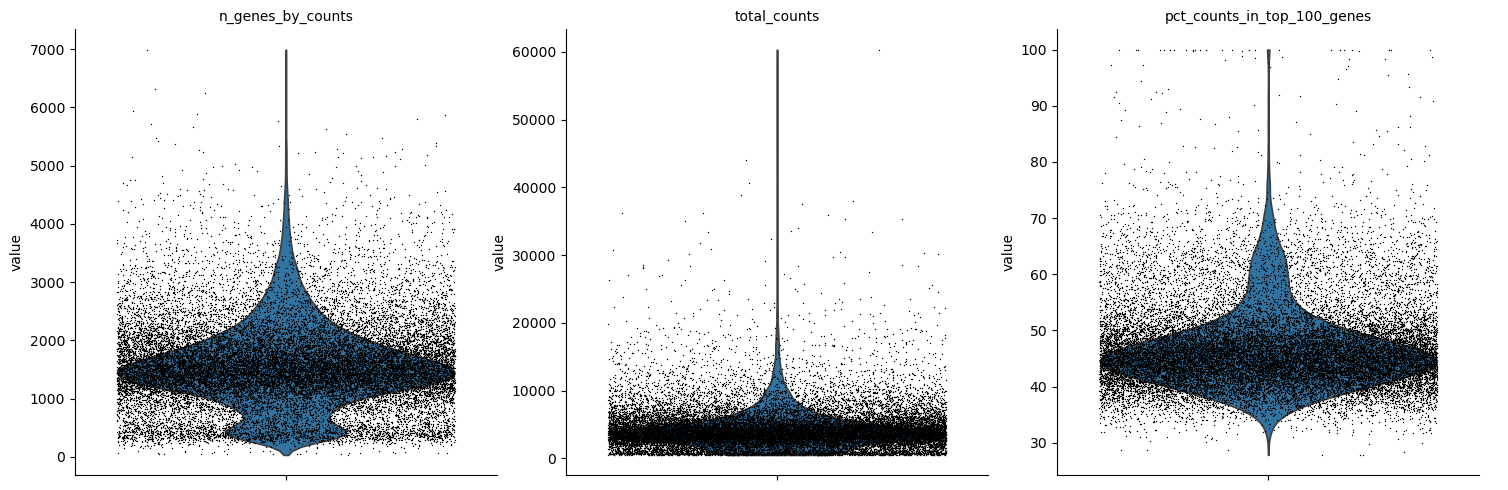

In [42]:
ax = sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_in_top_100_genes"],
    jitter=0.4,
    multi_panel=True,
    show=False,
)
ax.figure.savefig("cache/qc_metrics.png")

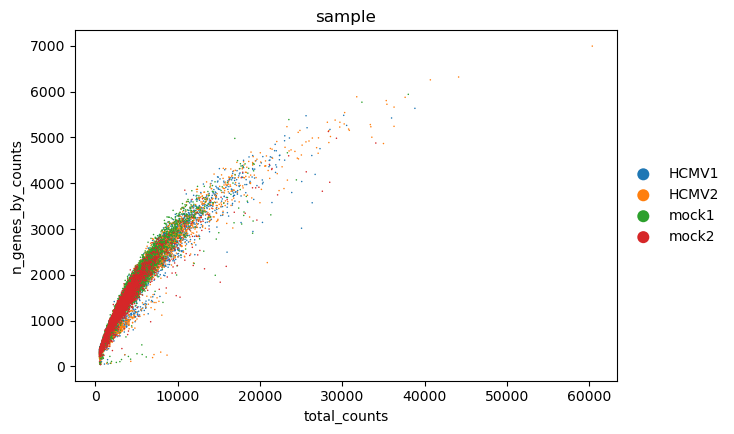

In [43]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="sample")

In [44]:
# sc.pp.subsample(adata, n_obs=int(adata.shape[0]*0.2), copy=False)
# adata

In [45]:
rename_dict = {
    "HCMV": "Infected",
    "mock": "Control",
}
rename = lambda x: rename_dict.get(x, x)
adata.obs["sample_type"] = adata.obs["sample"].str[:-1].apply(rename)

In [46]:
# https://decoupler-py.readthedocs.io/en/latest/notebooks/cell_annotation.html

# Normalize the data
# sc.pp.normalize_total(adata, target_sum=1e4)
adata.layers['raw_counts'] = adata.X.copy()
sc.pp.log1p(adata)
adata.layers['log_norm'] = adata.X.copy()

In [47]:
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)
adata.X[0].max()

6.035481432524756

In [48]:
# volcano plot
# https://nbviewer.org/github/theislab/diffxpy_tutorials/blob/master/diffxpy_tutorials/test/introduction_differential_testing.ipynb

In [49]:
from scipy.stats import ttest_ind

inf = adata[adata.obs.sample_type == "Infected"].X.T.tocsr()
ctl = adata[adata.obs.sample_type == "Control"].X.T.tocsr()

# volcano_data = ttest(inf, ctl, adata.var.index.tolist())
matA = inf.todense()
matB = ctl.todense()

res = ttest_ind(matA, matB, axis=1, equal_var=False, nan_policy='omit')
fc = matA.mean(axis=1)/matB.mean(axis=1)
# results = []
# for i, (ga, gb, l) in tqdm(enumerate(zip(matA, matB, labels)), total=len(labels)):
#     sa = (ga > 0).sum()
#     sb = (gb > 0).sum()
#     if sa < 3 or sb < 3: continue
#     va = np.array(ga[ga>0])[0]
#     vb = np.array(gb[gb>0])[0]
#     res = ttest_ind(va, vb, equal_var=False)
#     fc = matA.mean()/matB.mean()
#     results.append((i, l, fc, res.pvalue))

In [50]:
results = np.array(np.vstack((fc.T, res.pvalue)).T)
results.shape

(36601, 2)

In [51]:
from local.figures.template import BaseFigure, ApplyTemplate, go
from local.figures.colors import Color, COLORS, Palettes

In [54]:
# fig = BaseFigure()

# non_sig = results[results[:, 1] > 0.05]
# sig = results[results[:, 1] <= 0.05]

# for _res, _col in [
#     (sig, Palettes.PLOTLY[1]),
#     (non_sig, Color.Hex("#AAAAAA")),
# ]:
#     fig.add_trace(go.Scatter(
#         x=np.log2(_res[:, 0]), y=-np.log10(_res[:, 1]),
#         mode="markers", marker=dict(color=_col.color_value),
#         text=l,
#     ))
# fig = ApplyTemplate(fig)
# fig.show()

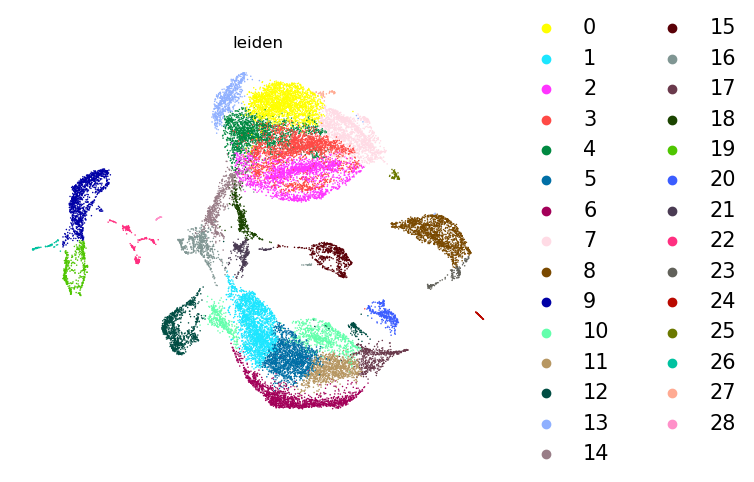

In [55]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')
# Restore X to be norm counts
dc.swap_layer(adata, 'log_norm', X_layer_key=None, inplace=True)
# Compute distances in the PCA space, and find cell neighbors
sc.pp.neighbors(adata, n_neighbors=12, n_pcs=40)
# Generate UMAP features
sc.tl.umap(
    adata,
    min_dist = 0.3,
    spread = 1,
)
# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.umap(
    adata, color='leiden',
    frameon=False, legend_fontweight='normal', legend_fontsize=15
)

In [56]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
0,CTRB1,False,Enterocytes,Endoderm,True,0.000000,0.004394,True,0.003311,0.020480,9606,GI tract,0.017
1,CTRB1,True,Acinar cells,Endoderm,True,1.000000,0.000629,True,0.957143,0.015920,9606,Pancreas,0.017
2,KLK1,True,Endothelial cells,Mesoderm,True,0.000000,0.008420,True,0.000000,0.014915,9606,Vasculature,0.013
3,KLK1,False,Goblet cells,Endoderm,True,0.588235,0.005039,True,0.903226,0.012408,9606,GI tract,0.013
4,KLK1,False,Epithelial cells,Mesoderm,True,0.000000,0.008233,True,0.225806,0.013758,9606,Epithelium,0.013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8456,SLC14A1,True,Urothelial cells,Mesoderm,True,0.000000,0.018170,True,0.000000,0.000000,9606,Urinary bladder,0.008
8457,UPK3A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8458,UPK1A,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000
8459,UPK2,True,Urothelial cells,Mesoderm,True,0.000000,0.000000,True,0.000000,0.000000,9606,Urinary bladder,0.000


In [57]:
# markers.to_csv(WORKSPACE_ROOT/"data/PanglaoDB.csv", index=False)

In [58]:
# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5) & (markers["organ"].isin({"Blood", "Immune system"}))]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

,genesymbol,canonical_marker,cell_type,germ_layer,human,human_sensitivity,human_specificity,mouse,mouse_sensitivity,mouse_specificity,ncbi_tax_id,organ,ubiquitiousness
106,LYZ,True,Neutrophils,Mesoderm,True,0.615385,0.038377,False,0.000000,0.000000,9606,Immune system,0.008
454,SERPINF1,True,Plasmacytoid dendritic cells,Mesoderm,True,1.000000,0.099684,True,0.000000,0.000000,9606,Immune system,0.057
813,CLEC7A,True,Dendritic cells,Mesoderm,True,0.625850,0.018719,True,0.023810,0.025092,9606,Immune system,0.030
814,CLEC7A,True,Macrophages,Mesoderm,True,0.750000,0.044025,True,0.375758,0.013585,9606,Immune system,0.030
823,ITGAX,True,Macrophages,Mesoderm,True,0.583333,0.014151,True,0.062626,0.003380,9606,Immune system,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8260,TRBC2,True,T cells,Mesoderm,True,0.940711,0.083362,True,0.000000,0.000000,9606,Immune system,0.066
8266,TRAC,True,T cytotoxic cells,Mesoderm,True,1.000000,0.131348,True,0.000000,0.000000,9606,Immune system,0.042
8267,TRAC,True,T cells,Mesoderm,True,0.972332,0.059544,True,0.000000,0.000000,9606,Immune system,0.042
8297,LCK,True,T cells,Mesoderm,True,0.648221,0.033004,True,0.705607,0.030902,9606,Immune system,0.048


In [59]:
adatax = sc.datasets.pbmc3k()
adatax

  0%|          | 0.00/5.58M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [ ]:
adatax.var

,gene_ids
index,
MIR1302-10,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC145205.1,ENSG00000215635
BAGE5,ENSG00000268590
CU459201.1,ENSG00000251180


In [ ]:
adx = sc.read_h5ad(WORKSPACE_ROOT/"scratch/work/b2/a965b755c050fc4a56cff7fa08498e/adata.umap_embed.h5ad")
adx

AnnData object with n_obs × n_vars = 25312 × 36601
    obs: 'barcode', 'sample', 'sample_type', 'leiden'
    var: 'locus', 'gene'
    uns: 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [ ]:
adx.var

,locus,gene
0,ENSG00000000003,TSPAN6
1,ENSG00000000005,TNMD
2,ENSG00000000419,DPM1
3,ENSG00000000457,SCYL3
4,ENSG00000000460,C1orf112
...,...,...
36596,ENSG00000288380,CRIPAK
36597,ENSG00000288398,AL109627.1
36598,ENSG00000288436,AC024558.2
36599,ENSG00000288459,AL512357.2


In [ ]:
if "gene" in adata.var.columns:
    adata.var.set_index("gene", inplace=True)

In [ ]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)

adata.obsm['ora_estimate']

11679 features of mat are empty, they will be removed.
Running ora on mat with 25312 samples and 24922 targets for 14 sources.


  0%|          | 0/25312 [00:00<?, ?it/s]

source,B cells,B cells naive,Dendritic cells,Erythroid-like and erythroid precursor cells,Gamma delta T cells,Macrophages,Mast cells,Monocytes,NK cells,Neutrophils,Plasma cells,Plasmacytoid dendritic cells,Platelets,T cells
0,8.046460,15.740408,8.598849,0.440296,-0.000000,0.810794,-0.0,1.815654,1.132491,0.395157,4.844330,2.780695,1.928399,1.825048
1,2.632574,4.844330,3.108825,-0.000000,-0.000000,0.810794,-0.0,0.981068,0.191684,0.395157,1.485621,1.202787,0.208023,0.191684
2,12.066370,12.468180,11.412942,1.179464,-0.000000,0.810794,-0.0,2.832518,1.132491,0.395157,2.180925,1.928399,0.620683,3.568514
3,9.883163,15.740408,9.959612,-0.000000,-0.000000,0.120570,-0.0,5.382753,0.579727,-0.000000,3.866871,4.827708,1.202787,1.825048
4,3.742739,3.866871,2.283322,-0.000000,-0.000000,1.995809,-0.0,0.981068,0.191684,0.395157,0.902516,3.749150,0.620683,0.579727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5141,1.681081,2.180925,5.041770,1.179464,0.191684,0.810794,-0.0,0.356709,1.825048,1.072422,0.902516,0.208023,1.928399,13.021400
5142,0.323509,0.902516,5.041770,0.440296,-0.000000,1.349258,-0.0,0.981068,1.132491,1.072422,0.902516,1.202787,1.928399,6.973872
5143,1.681081,2.180925,20.490476,0.440296,0.191684,5.484171,-0.0,2.832518,0.579727,1.971345,0.447192,0.620683,4.827708,1.132491
5144,1.681081,2.180925,7.326682,-0.000000,5.737270,1.995809,-0.0,5.382753,11.325481,1.072422,0.902516,0.620683,2.780695,9.761140


In [ ]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,0,rest,B cells,59.544023,5.264241,0.000000e+00,0.000000e+00
1,0,rest,B cells naive,53.042888,7.554400,0.000000e+00,0.000000e+00
2,0,rest,Plasma cells,45.250950,1.986003,0.000000e+00,0.000000e+00
3,0,rest,Plasmacytoid dendritic cells,45.062541,1.986898,0.000000e+00,0.000000e+00
4,0,rest,Monocytes,32.233607,1.775576,9.138552e-205,2.132329e-204
...,...,...,...,...,...,...,...
401,9,rest,T cells,-36.564478,-4.779353,8.208294e-199,2.298322e-198
402,9,rest,Plasma cells,-36.880206,-1.848405,2.427483e-203,8.496190e-203
403,9,rest,B cells,-39.994960,-4.558911,5.328071e-226,2.486433e-225
404,9,rest,B cells naive,-40.533782,-7.247324,5.946011e-229,4.162208e-228


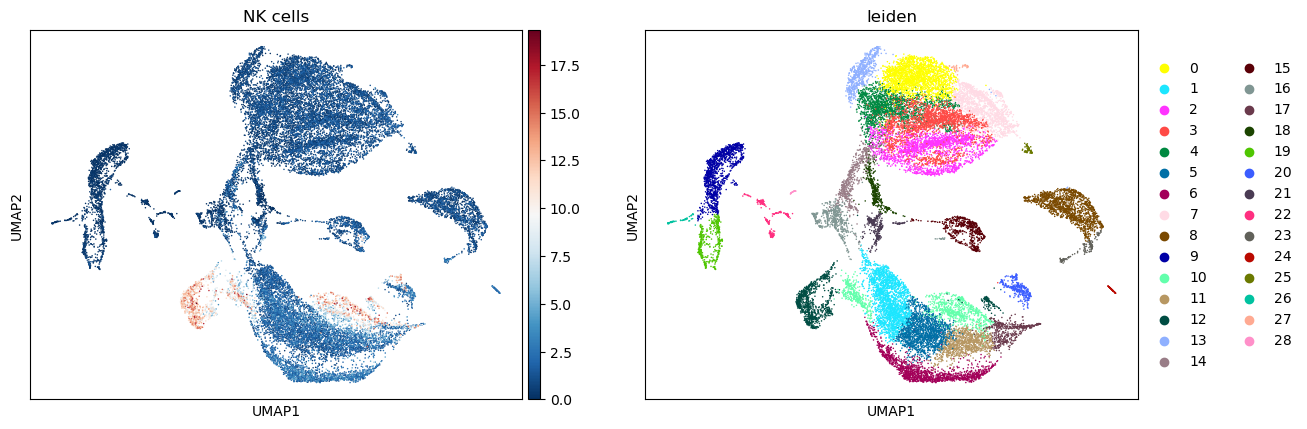

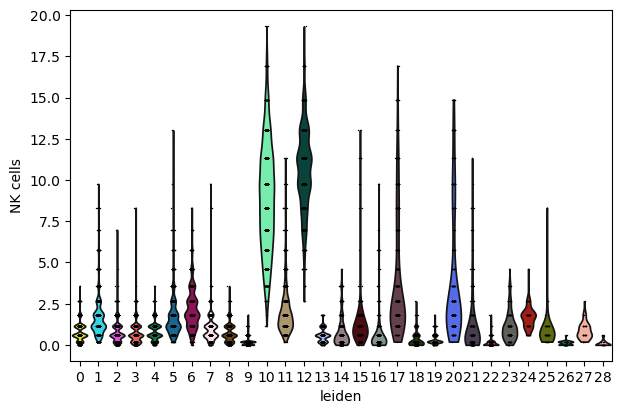

In [ ]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

In [ ]:
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['B cells', 'B cells naive', 'Plasma cells'],
 '1': ['T cells',
  'Erythroid-like and erythroid precursor cells',
  'Neutrophils'],
 '10': ['NK cells', 'Gamma delta T cells', 'T cells'],
 '11': ['T cells', 'Platelets', 'Neutrophils'],
 '12': ['Gamma delta T cells', 'NK cells', 'Platelets'],
 '13': ['B cells', 'Plasmacytoid dendritic cells', 'Plasma cells'],
 '14': ['Neutrophils', 'Plasmacytoid dendritic cells', 'B cells'],
 '15': ['Macrophages', 'Dendritic cells', 'Neutrophils'],
 '16': ['Neutrophils', 'Macrophages', 'Mast cells'],
 '17': ['T cells', 'Platelets', 'NK cells'],
 '18': ['Plasmacytoid dendritic cells', 'Mast cells', 'B cells'],
 '19': ['Macrophages', 'Neutrophils', 'Mast cells'],
 '2': ['B cells naive', 'B cells', 'Plasma cells'],
 '20': ['T cells', 'Dendritic cells', 'B cells naive'],
 '21': ['Neutrophils',
  'Mast cells',
  'Erythroid-like and erythroid precursor cells'],
 '22': ['Platelets',
  'Erythroid-like and erythroid precursor cells',
  'Mast cells'],
 '23':

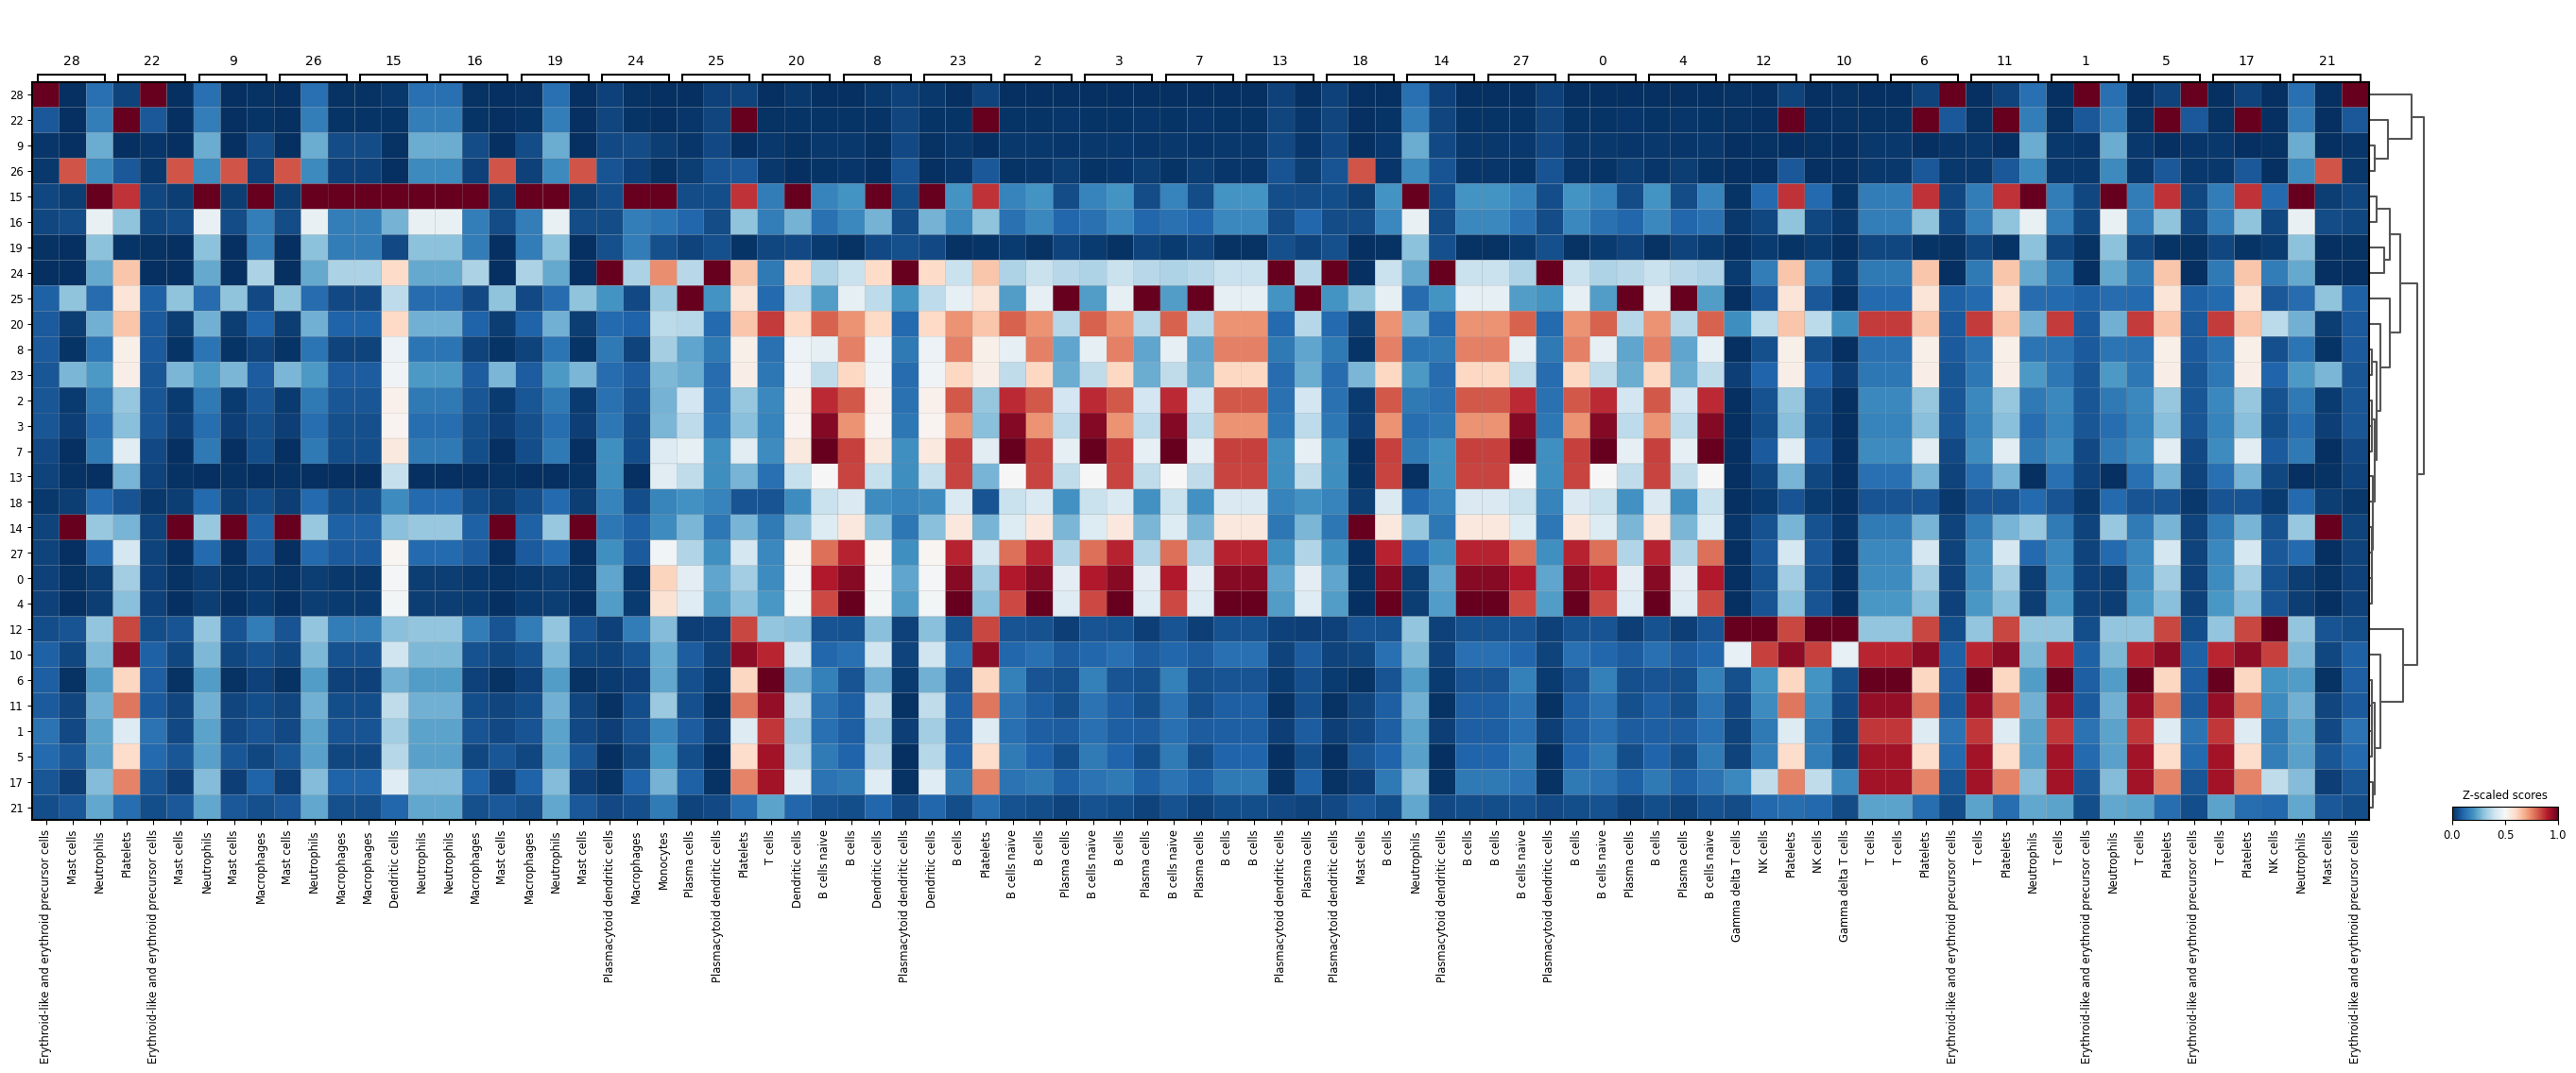

In [ ]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

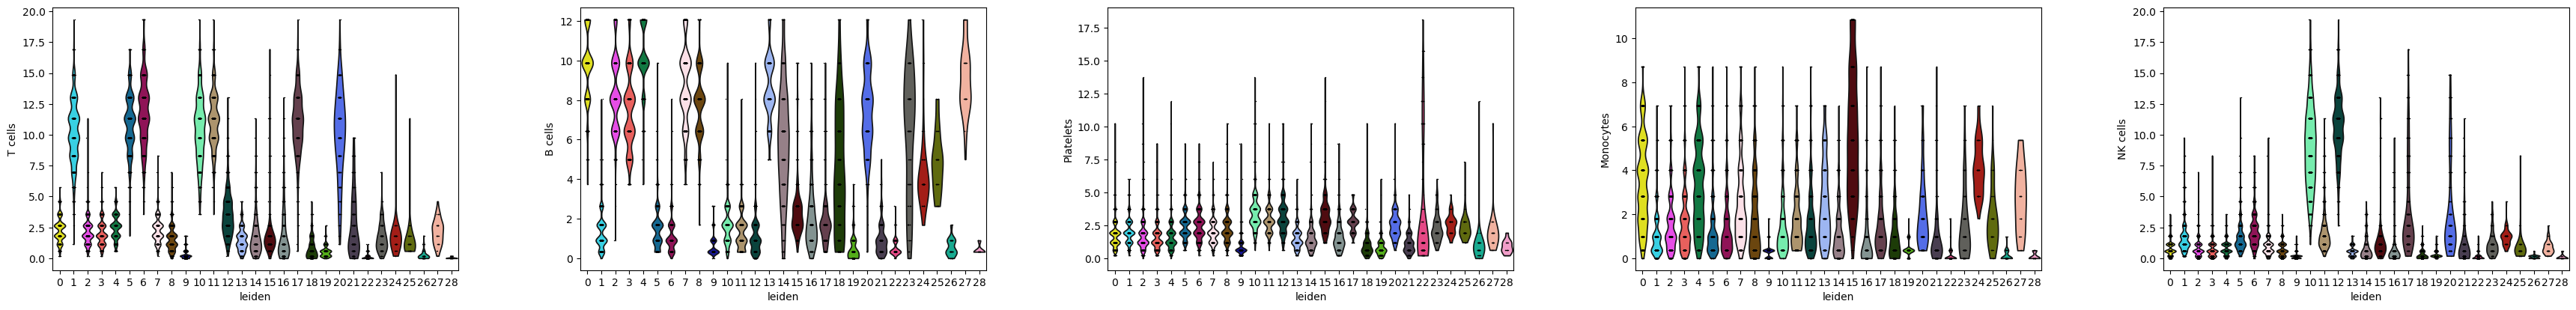

In [ ]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

In [ ]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict

{'0': 'B cells',
 '1': 'T cells',
 '10': 'NK cells',
 '11': 'T cells',
 '12': 'Gamma delta T cells',
 '13': 'B cells',
 '14': 'Neutrophils',
 '15': 'Macrophages',
 '16': 'Neutrophils',
 '17': 'T cells',
 '18': 'Plasmacytoid dendritic cells',
 '19': 'Macrophages',
 '2': 'B cells naive',
 '20': 'T cells',
 '21': 'Neutrophils',
 '22': 'Platelets',
 '23': 'Dendritic cells',
 '24': 'Plasmacytoid dendritic cells',
 '25': 'Plasma cells',
 '26': 'Mast cells',
 '27': 'B cells',
 '28': 'Erythroid-like and erythroid precursor cells',
 '3': 'B cells naive',
 '4': 'B cells',
 '5': 'T cells',
 '6': 'T cells',
 '7': 'B cells naive',
 '8': 'B cells',
 '9': 'Neutrophils'}

In [ ]:
# from umap import UMAP
# from sklearn.preprocessing import LabelEncoder

# model = UMAP(
#     n_components=2,
#     min_dist=0.7, spread=1,
#     n_neighbors=25,
#     target_weight=0.1,
# )
# encoder = LabelEncoder()
# y = encoder.fit_transform(adata.obs["cell_type"])
# adata.obsm["X_umap"] = model.fit_transform(adata.X)

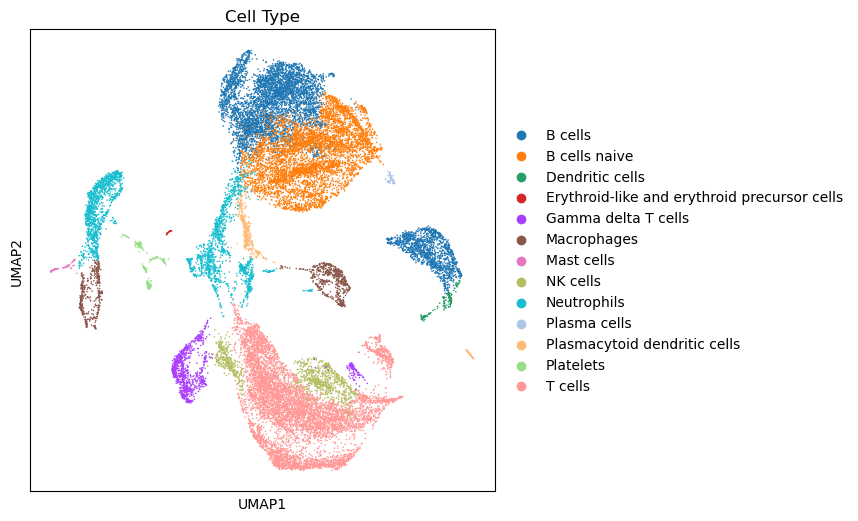

In [ ]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
ax = sc.pl.umap(adata, color='cell_type', s=5, title="Cell Type", show=False)
ax.figure.set_figwidth(6)
ax.figure.set_figheight(6)
ax.figure.show()

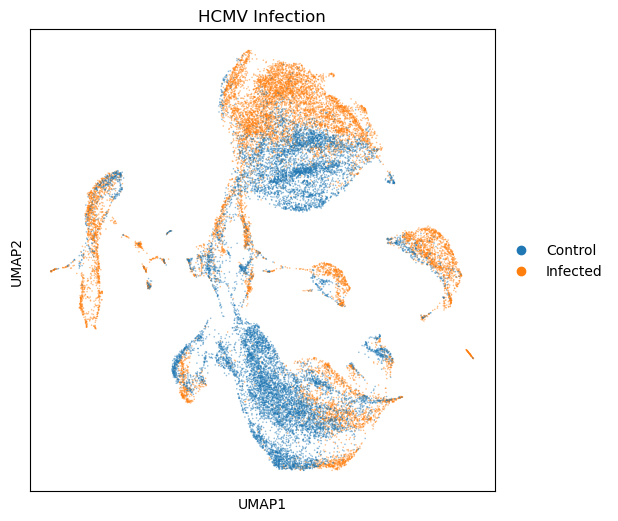

In [ ]:
# Visualize
ax = sc.pl.umap(adata, color='sample_type', s=5, alpha=0.5, title="HCMV Infection", show=False)
ax.figure.set_figwidth(6)
ax.figure.set_figheight(6)
ax.figure.show()

In [ ]:
from local.figures.template import BaseFigure, ApplyTemplate, go
from local.figures.colors import Color, COLORS, Palettes

In [ ]:
all_counts = {}
for sample in adata.obs["sample_type"].unique():
    _df = adata.obs
    _df = _df[_df["sample_type"] == sample]
    counts = _df[["cell_type"]].value_counts()
    meta = all_counts.get(sample, {})
    for k, v in counts.items():
        meta[k[0]] = v
    all_counts[sample] = meta

colors = {
    "Control": Palettes.PLOTLY[0],
    "Infected": Palettes.PLOTLY[1],
}
fig = BaseFigure()
c = np.array([v for data in all_counts.values() for v in data.values()]).sum()
m = 0
for sample, data in all_counts.items():
    a = -1 if "Infected" in sample else 1
    fig.add_trace(go.Bar(
        y=list(data.keys()),
        x=[a*v/c for v in data.values()],
        name=sample,
        marker = dict(
            color=colors[sample].color_value,
            line_width=0,
        ),
        orientation='h',
    ))
    m = max(m, max(data.values())/c)
rx = m*1.1
fig = ApplyTemplate(
    fig,
    default_xaxis=dict(dtick=0.2, range=[-rx, rx], title="Fraction of Cells"),
    default_yaxis=dict(title="Cell Type"),
    layout=dict(
        width=800, height=350,
        barmode='relative',
        font_size=14,
    ),
)
fig.show()

KeyError: "None of [Index(['cell_type'], dtype='object')] are in the [columns]"

In [ ]:
adata.var.index

CategoricalIndex(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH',
                  'FUCA2', 'GCLC', 'NFYA',
                  ...
                  'AC010332.3', 'FP325313.3', 'AL132709.8', 'AC079772.1',
                  'AL160391.1', 'CRIPAK', 'AL109627.1', 'AC024558.2',
                  'AL512357.2', 'AL138899.3'],
                 categories=['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', ..., 'ZYX', 'ZZEF1', 'hsa-mir-423', 'hsa-mir-1253'], ordered=False, dtype='category', name='gene', length=36601)

In [ ]:
adata.write("cache/adata.h5ad", compression="gzip")